In [7]:
import numpy as np
M_range     = np.arange(0.001, 0.01, 0.001)

   Distance  Variance  Calculated_Mass_Fraction
0  0.006858  0.216238                  0.683744
1  0.011436  0.217743                  0.679602
2  0.016015  0.219980                  0.673263
3  0.020593  0.222925                  0.664545
4  0.025172  0.226366                  0.653734


<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
/var/folders/rc/1wfb73xj1w9bkk2c3pz8nbym0000gn/T/ipykernel_40859/2719974957.py:38: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mean Mass Fraction $\overline{c}$")


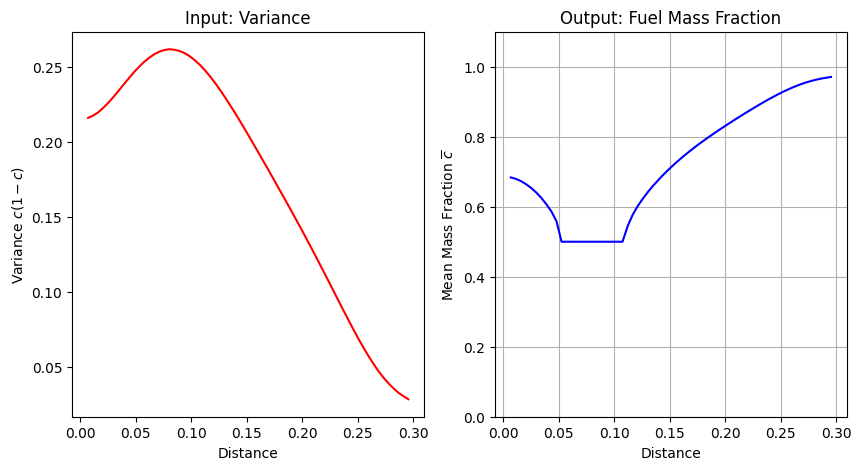

    Distance  Variance  Calculated_Mass_Fraction
0   0.006858  0.216238                  0.683744
1   0.011436  0.217743                  0.679602
2   0.016015  0.219980                  0.673263
3   0.020593  0.222925                  0.664545
4   0.025172  0.226366                  0.653734
..       ...       ...                       ...
64  0.277827  0.038912                  0.959443
65  0.282406  0.035515                  0.963125
66  0.286985  0.032569                  0.966295
67  0.291563  0.030268                  0.968755
68  0.295517  0.028419                  0.970724

[69 rows x 3 columns]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the data
# Assuming no headers based on the snippet, assigning logical names
df = pd.read_csv('/Users/raja/Library/CloudStorage/OneDrive-SharedLibraries-McGillUniversity/CombustionDynamicsF2025 - General/04. Code - git repo/src/data/csv/fig5-35.csv', header=None, names=['Distance', 'Variance'])

# 2. Define the Bernoulli conversion function
def get_mass_fraction(variance):
    # Cap variance at 0.25 to prevent math domain errors (sqrt of negative)
    # This handles the noise in your data (values like 0.26)
    variance = min(variance, 0.25)
    
    # We choose the (+) branch because the flow starts as pure fuel (c=1)
    # and is mixing downwards.
    c = 0.5 + 0.5 * np.sqrt(1 - 4 * variance)
    return c

# 3. Apply the function
df['Calculated_Mass_Fraction'] = df['Variance'].apply(get_mass_fraction)

# 4. Display or Plot results
print(df.head())

# Optional: Visualization to see the profile
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df['Distance'], df['Variance'], color='red')
plt.title("Input: Variance")
plt.xlabel("Distance")
plt.ylabel("Variance $c(1-c)$")

plt.subplot(1, 2, 2)
plt.plot(df['Distance'], df['Calculated_Mass_Fraction'], color='blue')
plt.title("Output: Fuel Mass Fraction")
plt.xlabel("Distance")
plt.ylabel("Mean Mass Fraction $\overline{c}$")
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()
print(df)

----------------------------------------
ANALYSIS RESULTS
----------------------------------------
Injection Location: Centerline (eta = 0)
Current Centerline Mass Fraction: 0.68 (Rich)
Current Edge Mass Fraction (eta=0.3): 0.03 (Lean)
----------------------------------------
Spatial Mixing Index (Uniformity): 18.92%
  > Target for 'Well Mixed':       90.00%
  > Conclusion: The flow at this location is NOT well mixed.
----------------------------------------


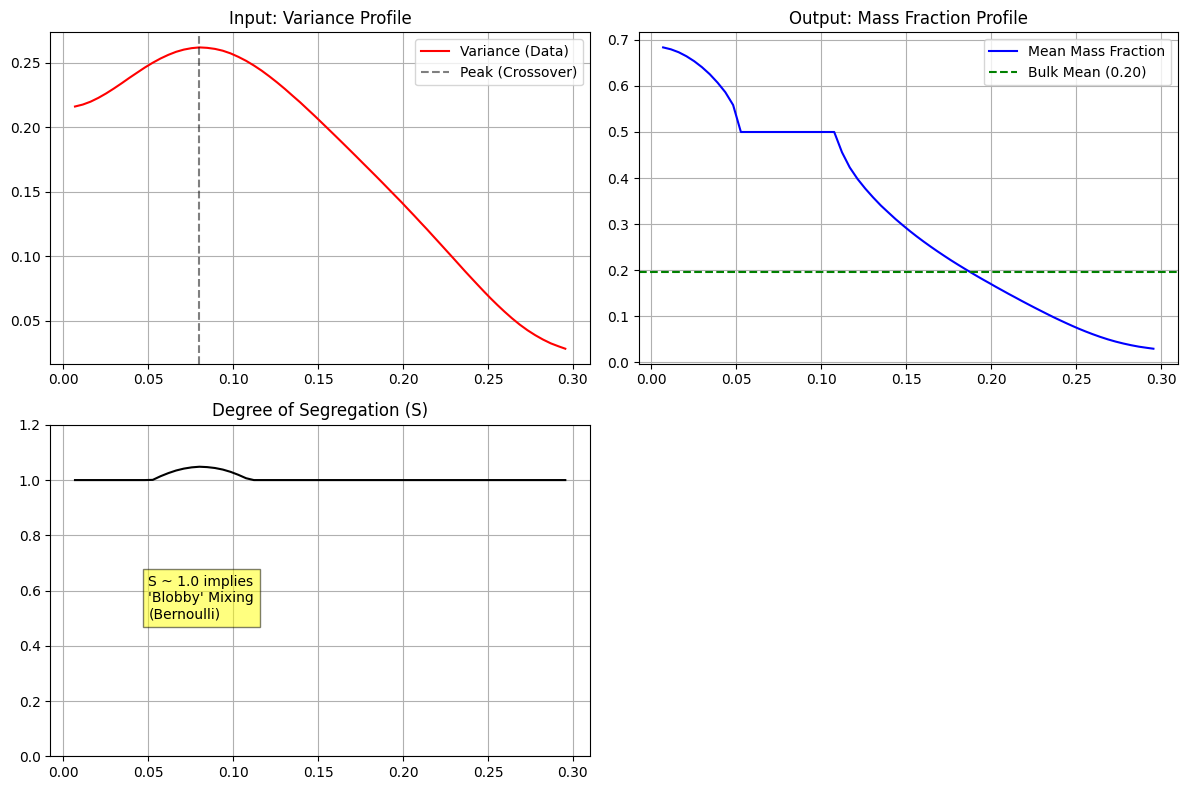

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_mixing_profile(csv_file):
    # 1. Load the Data
    # We assume the columns are [eta, variance]
    df = pd.read_csv(csv_file, header=None, names=['eta', 'variance'])
    
    # 2. Calculate Mean Mass Fraction (c_bar)
    # Logic: The jet has a RICH core (c > 0.5) and a LEAN edge (c < 0.5).
    # The crossover happens at the location of Maximum Variance (where c ~ 0.5).
    
    # Find the index/location of the peak variance
    peak_idx = df['variance'].idxmax()
    peak_eta = df.loc[peak_idx, 'eta']
    
    mass_fractions = []
    
    for i, row in df.iterrows():
        # Cap variance at 0.25 to avoid math errors (sqrt of negative)
        # This handles noise where variance > 0.25 (Bernoulli limit)
        v = min(row['variance'], 0.25)
        
        # Invert the parabola: c(1-c) = Var  =>  c = (1 +/- sqrt(1-4v))/2
        term = np.sqrt(1 - 4 * v) / 2.0
        
        if i <= peak_idx:
            # Region 1: Core (Rich Branch)
            # We are closer to the injector, so concentration is high (> 0.5)
            c = 0.5 + term
        else:
            # Region 2: Edge (Lean Branch)
            # We are far from the center, so concentration is low (< 0.5)
            c = 0.5 - term
            
        mass_fractions.append(c)
        
    df['mean_c'] = mass_fractions
    
    # 3. Calculate "Degree of Segregation" (Unmixedness)
    # Segregation S = Variance_measured / Variance_max_possible
    # S = 1.0 means perfectly segregated (Bernoulli state, 0% mixed molecularly)
    # S = 0.0 means perfectly mixed (Homogeneous)
    df['max_possible_var'] = df['mean_c'] * (1 - df['mean_c'])
    # Avoid division by zero at edges
    df['segregation_index'] = df['variance'] / df['max_possible_var'].replace(0, 1e-9)
    
    # 4. Calculate Spatial Mixing Index (Uniformity) across this profile
    # We need to integrate over the area (A ~ 2*pi*r*dr). Since eta ~ r, we use eta.
    # This tells us how uniform the fuel distribution is radially.
    d_eta = np.diff(df['eta']).mean()
    df['area_weight'] = 2 * np.pi * df['eta'] * d_eta
    
    total_area = df['area_weight'].sum()
    bulk_mean_c = (df['mean_c'] * df['area_weight']).sum() / total_area
    
    # Spatial Variance = Sum( (c - c_bulk)^2 * A ) / Total_A
    spatial_variance = ((df['mean_c'] - bulk_mean_c)**2 * df['area_weight']).sum() / total_area
    spatial_std = np.sqrt(spatial_variance)
    
    # Mixing Index = 1 - (Standard_Deviation / Mean)
    # 1.0 = Perfectly Uniform, 0.0 = Very Poor
    mixing_index = 1 - (spatial_std / bulk_mean_c)

    # Output Results
    print("-" * 40)
    print(f"ANALYSIS RESULTS")
    print("-" * 40)
    print(f"Injection Location: Centerline (eta = 0)")
    print(f"Current Centerline Mass Fraction: {df['mean_c'].iloc[0]:.2f} (Rich)")
    print(f"Current Edge Mass Fraction (eta=0.3): {df['mean_c'].iloc[-1]:.2f} (Lean)")
    print("-" * 40)
    print(f"Spatial Mixing Index (Uniformity): {mixing_index:.2%}")
    print(f"  > Target for 'Well Mixed':       90.00%")
    print(f"  > Conclusion: The flow at this location is NOT well mixed.")
    print("-" * 40)
    
    # 5. Plotting
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Variance (Input)
    plt.subplot(2, 2, 1)
    plt.plot(df['eta'], df['variance'], 'r-', label='Variance (Data)')
    plt.axvline(peak_eta, color='k', linestyle='--', alpha=0.5, label='Peak (Crossover)')
    plt.title('Input: Variance Profile')

    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Calculated Mass Fraction (Output)
    plt.subplot(2, 2, 2)
    plt.plot(df['eta'], df['mean_c'], 'b-', label='Mean Mass Fraction')
    plt.axhline(bulk_mean_c, color='g', linestyle='--', label=f'Bulk Mean ({bulk_mean_c:.2f})')
    plt.title('Output: Mass Fraction Profile')

    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Degree of Segregation
    plt.subplot(2, 2, 3)
    plt.plot(df['eta'], df['segregation_index'], 'k-')
    plt.title('Degree of Segregation (S)')

    plt.ylim(0, 1.2)
    plt.grid(True)
    plt.text(0.05, 0.5, "S ~ 1.0 implies\n'Blobby' Mixing\n(Bernoulli)", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_mixing_profile('/Users/raja/Library/CloudStorage/OneDrive-SharedLibraries-McGillUniversity/CombustionDynamicsF2025 - General/04. Code - git repo/src/data/csv/fig5-35.csv')